    Author: DANIEL TWENEBOAH ANYIMADU

# Enhancing Multiclass Skin Lesion Classification: A Deep Learning vs. Hybrid Deep Learning-Machine Learning Comparison

**-**    Skin cancer remains a global health concern despite significant advances regarding its treatment modalities.

**-**    Early diagnosis is required to alleviate the increasing incidence and associated morbidity and mortality rates.

**-**    Here, we leverage pure Deep Learning (DL) and hybrid Deep Learning (DL) - Machine Learning (ML) techniques by comparing these two approaches, while enhancing multiclass skin lesion classification.

**NB: Hybrid Deep Learning (DL)-Machine Learning (ML) Approach Using HAM10000 Dataset**

# IMPORT LIBRARIES (MODULES)

In [1]:
# Libraries for exploratory data analysis (EDA)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 as cv
from PIL import Image
from glob import glob
import random

# Libraries for data preprocessing, augmentation and creating data generators
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Libraries for feature extraction using deep learning
import keras
from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, Flatten, Dense
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

# Libraries for building and training machine learning model
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Libraries for evaluation metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score, roc_curve, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# EXPLORATORY DATA ANALYSIS (EDA)

**Handling Groundtruth:**

    Loading and visualizing the metadata (contains groundtruth) from a csv file

In [2]:
# Define file path
dir_path = "C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SEM_2_(ITALY)/Machine_and_Deep_Learning/PROJECT/HAM10000/"  # Set path to directory
groundtruth_path = os.path.join(dir_path, "HAM10000_metadata.csv")                                                  # Set path to groundtruth

# Load metadata (contains groundtruth) data to a dataframe
groundtruth_df = pd.read_csv(groundtruth_path) # header = None
groundtruth_df.head() # Visualize the first 5 rows of the groundtruth data

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


        Class distribution of dx (diagnosis): 
    
    "Melanoma (mel)", 
    "Melanocytic nevus (nv)", 
    "Basal cell carcinoma (bcc)", 
    "Actinic keratosis / Bowen’s disease (intraepithelial carcinoma) (akiec)", 
    "Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis) (bkl)", 
    "Dermatofibroma (df)", 
    "Vascular lesion (vasc)"

In [3]:
cd = groundtruth_df["dx"].value_counts(); print(cd)

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


    Plot a bar graph of the class distribution

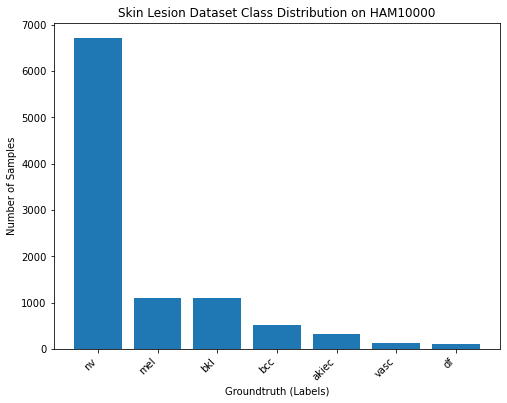

In [4]:
plt.figure(figsize = (8, 6))
plt.bar(cd.index, cd.values)
plt.title("Skin Lesion Dataset Class Distribution on HAM10000"); plt.xlabel("Groundtruth (Labels)"); plt.ylabel("Number of Samples"); plt.xticks(rotation = 45, ha = "right")
plt.show()

**Handling Training Dataset (HAM10000):**

    Mapping "HAM10000_images_part_1" & "HAM10000_images_part_2" to "image_id (HAM_0000118, ISIC_0027419)"

In [5]:
# Get a list of image path using glob and then create a dictionary to map image file to "image_id"
image_path_1 = glob(os.path.join(dir_path, "HAM10000_images_part_1/*.jpg")) # Set path to image directory
image_path_2 = glob(os.path.join(dir_path, "HAM10000_images_part_2/*.jpg")) # Set path to image directory
image_path = image_path_1 + image_path_2

image_file = {os.path.splitext(os.path.basename(path))[0] :path for path in image_path}

# Add image file column to the groundtruth dataframe
groundtruth_df["image_file"] = groundtruth_df["image_id"].map(image_file)
groundtruth_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,image_file
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...


    Visualization of "HAM10000_images"

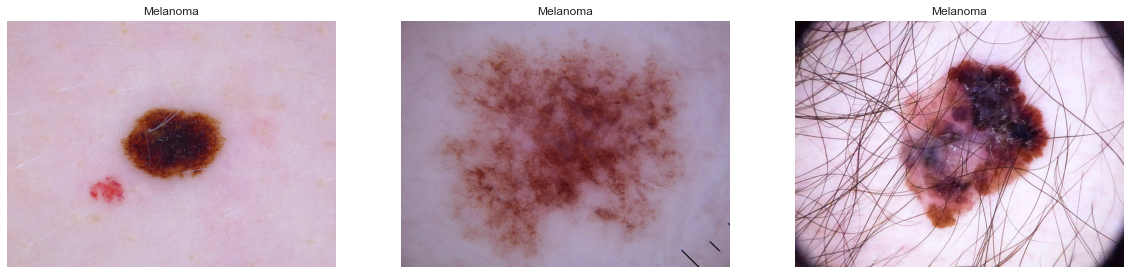

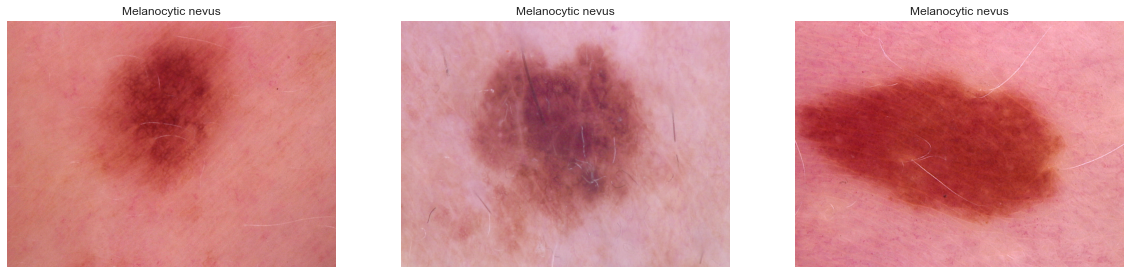

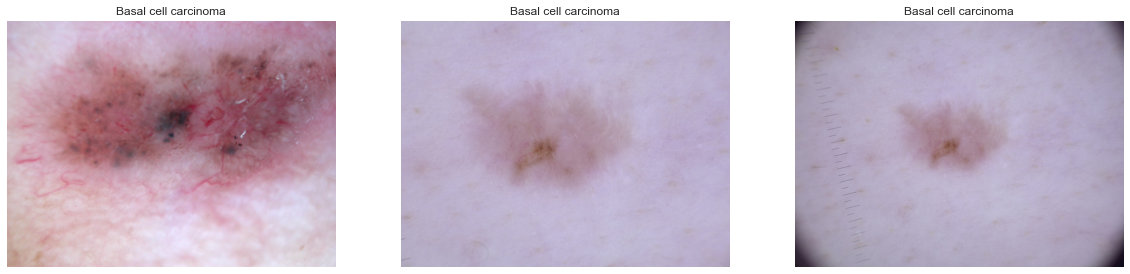

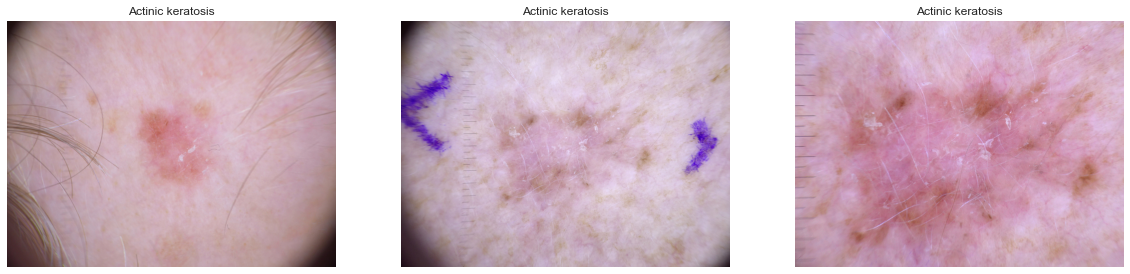

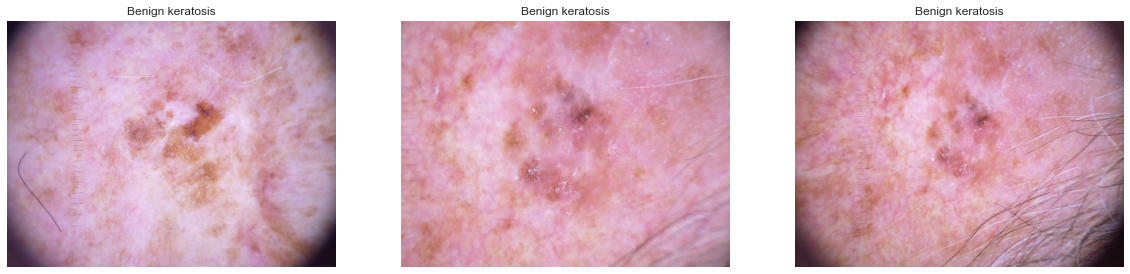

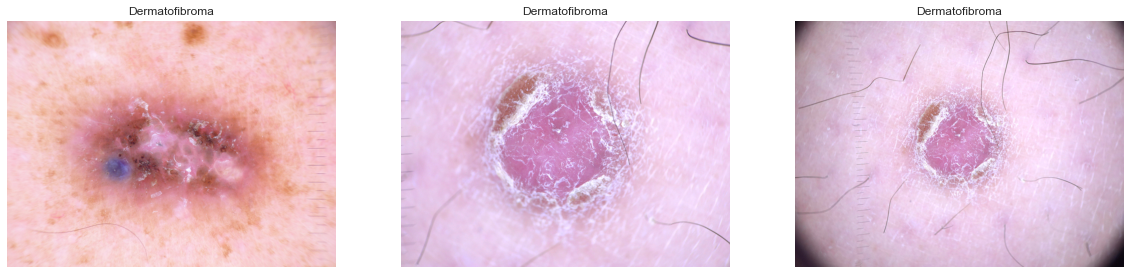

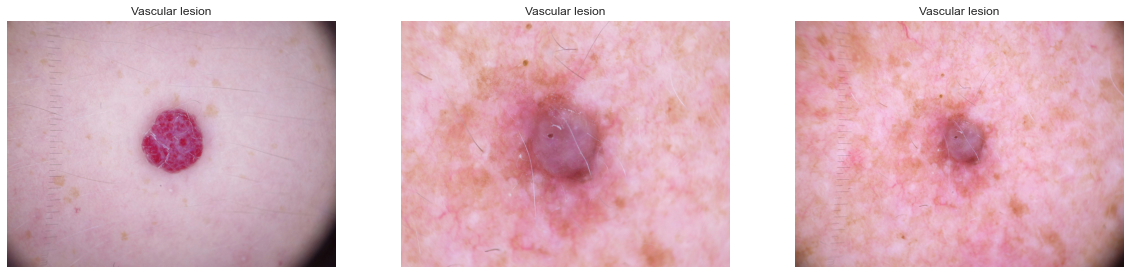

In [6]:
sns.set_style("white")

plt.figure(figsize = [20, 15]) # Melanoma (mel) images
for i, image_name in enumerate(groundtruth_df["image_file"][1212:1215]):
    image = cv.imread(image_name)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.subplot(1, 3, i + 1); plt.imshow(image); plt.axis("off"); plt.title("Melanoma")
    
plt.show()


plt.figure(figsize = [20, 15]) # Melanocytic nevus (nv) images
for i, image_name in enumerate(groundtruth_df["image_file"][2977:2980]):
    image = cv.imread(image_name)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.subplot(1, 3, i + 1); plt.imshow(image); plt.axis("off"); plt.title("Melanocytic nevus")
    
plt.show()


plt.figure(figsize = [20, 15]) # Basal cell carcinoma (bcc) images
for i, image_name in enumerate(groundtruth_df["image_file"][2463:2466]):
    image = cv.imread(image_name)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.subplot(1, 3, i + 1); plt.imshow(image); plt.axis("off"); plt.title("Basal cell carcinoma")
    
plt.show()


plt.figure(figsize = [20, 15]) # Actinic keratosis / Bowen’s disease (intraepithelial carcinoma) (akiec) images
for i, image_name in enumerate(groundtruth_df["image_file"][9688:9691]):
    image = cv.imread(image_name)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.subplot(1, 3, i + 1); plt.imshow(image); plt.axis("off"); plt.title("Actinic keratosis")
    
plt.show()


plt.figure(figsize = [20, 15]) # Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis) (bkl) images
for i, image_name in enumerate(groundtruth_df["image_file"][1:4]):
    image = cv.imread(image_name)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.subplot(1, 3, i + 1); plt.imshow(image); plt.axis("off"); plt.title("Benign keratosis")
    
plt.show()


plt.figure(figsize = [20, 15]) # Dermatofibroma (df) images
for i, image_name in enumerate(groundtruth_df["image_file"][1096:1099]):
    image = cv.imread(image_name)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.subplot(1, 3, i + 1); plt.imshow(image); plt.axis("off"); plt.title("Dermatofibroma")
    
plt.show()


plt.figure(figsize = [20, 15]) # Vascular lesion (vasc) images
for i, image_name in enumerate(groundtruth_df["image_file"][2321:2324]):
    image = cv.imread(image_name)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.subplot(1, 3, i + 1); plt.imshow(image); plt.axis("off"); plt.title("Vascular lesion")
    
plt.show()

# PERFORM DATA PREPROCESSING AND LABELING

    Combine 
    "Melanoma (mel):1", "Melanocytic nevus (nv):2", "Basal cell carcinoma (bcc):3", "Actinic keratosis / Bowen’s disease   (intraepithelial carcinoma) (akiec):4", "Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis) (bkl):5", "Dermatofibroma (df):6", "Vascular lesion (vasc):7" classes

In [7]:
groundtruth_df["classes"] = groundtruth_df["dx"]


# Map "classes" to their respective label values
labels = {"mel":1, "nv":2, "bcc":3, "akiec":4, "bkl":5, "df":6, "vasc":7}
groundtruth_df["labels"] = groundtruth_df["classes"].map(labels)

groundtruth_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,image_file,classes,labels
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,bkl,5
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,bkl,5
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,bkl,5
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,bkl,5
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,bkl,5


    Class distribution of "classes"

In [8]:
class_counts = groundtruth_df["classes"].value_counts()
print("Total number of samples: ", len(groundtruth_df["classes"]))

Total number of samples:  10015


    Converting image pixels into a normalized numpy array for further processing

In [9]:
groundtruth_df["image_pixel"] = groundtruth_df["image_file"].map(lambda x: np.asarray(Image.open(x).resize((64, 64))))

# Convert image pixels to numpy array and normalize (0:255) them
image_pixel = np.asarray(groundtruth_df['image_pixel'].tolist())
image_pixel = image_pixel/255

groundtruth_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,image_file,classes,labels,image_pixel
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,bkl,5,"[[[191, 152, 194], [191, 153, 195], [192, 149,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,bkl,5,"[[[23, 13, 23], [25, 14, 28], [37, 24, 46], [6..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,bkl,5,"[[[186, 129, 140], [192, 136, 151], [198, 143,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,bkl,5,"[[[24, 11, 19], [36, 20, 30], [64, 38, 50], [9..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,bkl,5,"[[[139, 95, 118], [158, 114, 138], [178, 133, ..."


#  RESAMPLING AND DATA GENERATORS 
**TASK : PERFORM MULTICLASS CLASSIFICATION**

     Resample the training data: "mel":1, "nv":2, "bcc":3, "akiec":4, "bkl":5, "df":6, "vasc":7, to ensure = # of samples.

In [10]:
mel_data = groundtruth_df[groundtruth_df["labels"] == 1]
nv_data = groundtruth_df[groundtruth_df["labels"] == 2]
bcc_data = groundtruth_df[groundtruth_df["labels"] == 3]
akiec_data = groundtruth_df[groundtruth_df["labels"] == 4]
bkl_data = groundtruth_df[groundtruth_df["labels"] == 5]
df_data = groundtruth_df[groundtruth_df["labels"] == 6]
vasc_data = groundtruth_df[groundtruth_df["labels"] == 7]

# Given class distribution
mel_cases = 1113; nv_cases = 6705; bcc_cases = 514; akiec_cases = 327; bkl_cases = 1099; df_cases = 115; vasc_cases = 142

# Calculate the target number of samples for each class (upsampling)
target_samples = 2000 # max(mel_cases, nv_cases, bcc_cases, akiec_cases, bkl_cases, df_cases, vasc_cases)

# Upsampling "" and "" and downsample ""
nv_downsampled = resample(nv_data, replace = False, n_samples = target_samples, random_state = 42)               # Without replacement
mel_upsampled = resample(mel_data, replace = True, n_samples = target_samples, random_state = 42)                # With replacement
bcc_upsampled = resample(bcc_data, replace = True, n_samples = target_samples, random_state = 42)                # With replacement
akiec_upsampled = resample(akiec_data, replace = True, n_samples = target_samples, random_state = 42)            # With replacement
bkl_upsampled = resample(bkl_data, replace = True, n_samples = target_samples, random_state = 42)                # With replacement
df_upsampled = resample(df_data, replace = True, n_samples = target_samples, random_state = 42)                  # With replacement
vasc_upsampled = resample(vasc_data, replace = True, n_samples = target_samples, random_state = 42)              # With replacement

# Shuffle resampled data to avoid any learning bias
resampled_data = pd.concat([nv_downsampled, mel_upsampled, bcc_upsampled, akiec_upsampled, bkl_upsampled, df_upsampled, vasc_upsampled])
resampled_data = resampled_data.sample(frac = 1, random_state = 42)

    Plot of resampled skin lesion dataset class distribution

    Split the "resampled_data" into: training = 70%, test = 30%

In [11]:
# Separate data for each class
mel_data = resampled_data[resampled_data["classes"] == "mel"]
nv_data = resampled_data[resampled_data["classes"] == "nv"]
bcc_data = resampled_data[resampled_data["classes"] == "bcc"]
akiec_data = resampled_data[resampled_data["classes"] == "akiec"]
bkl_data = resampled_data[resampled_data["classes"] == "bkl"]
df_data = resampled_data[resampled_data["classes"] == "df"]
vasc_data = resampled_data[resampled_data["classes"] == "vasc"]

# Split the data for each class into training and test sets
X_train_mel, X_test_mel, y_train_mel, y_test_mel = train_test_split(mel_data["image_pixel"], mel_data["classes"], test_size = 0.3, random_state = 42)
X_train_nv, X_test_nv, y_train_nv, y_test_nv = train_test_split(nv_data["image_pixel"], nv_data["classes"], test_size = 0.3, random_state = 42)
X_train_bcc, X_test_bcc, y_train_bcc, y_test_bcc = train_test_split(bcc_data["image_pixel"], bcc_data["classes"], test_size = 0.3, random_state = 42)
X_train_akiec, X_test_akiec, y_train_akiec, y_test_akiec = train_test_split(akiec_data["image_pixel"], akiec_data["classes"], test_size = 0.3, random_state = 42)
X_train_bkl, X_test_bkl, y_train_bkl, y_test_bkl = train_test_split(bkl_data["image_pixel"], bkl_data["classes"], test_size = 0.3, random_state = 42)
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(df_data["image_pixel"], df_data["classes"], test_size = 0.3, random_state = 42)
X_train_vasc, X_test_vasc, y_train_vasc, y_test_vasc = train_test_split(vasc_data["image_pixel"], vasc_data["classes"], test_size = 0.3, random_state = 42)

# Combine the training and test sets for each class
X_train = pd.concat([X_train_mel, X_train_nv, X_train_bcc, X_train_akiec, X_train_bkl, X_train_df, X_train_vasc])
y_train = pd.concat([y_train_mel, y_train_nv, y_train_bcc, y_train_akiec, y_train_bkl, y_train_df, y_train_vasc])
X_test = pd.concat([X_test_mel, X_test_nv, X_test_bcc, X_test_akiec, X_test_bkl, X_test_df, X_test_vasc])
y_test = pd.concat([y_test_mel, y_test_nv, y_test_bcc, y_test_akiec, y_test_bkl, y_test_df, y_test_vasc])

# Shuffle the data to avoid any learning bias
X_train, y_train = shuffle(X_train, y_train, random_state = 42)
X_test, y_test = shuffle(X_test, y_test, random_state = 42)

# Convert the image pixels to numpy arrays
X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())

# BUILD CNN BASED DEEP LEARNING MODEL

    CNN model implementation

In [12]:
model = Sequential()

model.add(Conv2D(256, (1, 1), activation = "relu", input_shape = (64, 64, 3))) # First Layer (Input Layer)
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation = "relu", input_shape = (64, 64, 3))) # Second Layer (Hidden Layer)
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (5, 5), activation = "relu", input_shape = (64, 64, 3))) # Third Layer (Output Layer)
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 256)       1024      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 128)       0

# Training machine learning (ML) models with extracted features

    Feature Engineering: Feature extraction, Feature scaling, Feature transformation (PCA)

In [13]:
# Extract features from CNN to train ML models
X_train = model.predict(X_train)

# Normalizing the 
# -----: (1) training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# -----: (2) test data
X_test = scaler.transform(model.predict(X_test))

# Apply PCA on training and test data
pca = PCA(n_components = 70)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

132/132 [==============================] - 18s 136ms/step


In [14]:
# RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
cv_rfc = cross_val_score(rfc, X_train_pca, y_train, cv = 5)
rfc.fit(X_train_pca, y_train)
pred_rfc = rfc.predict(X_test_pca)
test_acc_rfc = accuracy_score(y_test, pred_rfc)

print(f"RFC cross-validation score: {cv_rfc}")
print(f"RFC test accuracy: {test_acc_rfc}\n")

RFC cross-validation score: [0.90357143 0.88928571 0.90459184 0.90918367 0.90357143]
RFC test accuracy: 0.9221428571428572



    Train ML models on PCA-transformed data

In [15]:
# RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
cv_rfc = cross_val_score(rfc, X_train_pca, y_train, cv = 5)
rfc.fit(X_train_pca, y_train)
pred_rfc = rfc.predict(X_test_pca)
test_acc_rfc = accuracy_score(y_test, pred_rfc)

print(f"RFC cross-validation score: {cv_rfc}")
print(f"RFC test accuracy: {test_acc_rfc}\n")

RFC cross-validation score: [0.90357143 0.88928571 0.90459184 0.90918367 0.90357143]
RFC test accuracy: 0.9221428571428572



# EVALUATION METRICS 

    Make predictions on the test data

In [16]:
# Calculate evaluation metrics
print(f"\n----- RANDOM FOREST EVALUATION METRICS -----\n")
accuarcy_rfc = accuracy_score(y_test, pred_rfc); print(f"accuracy: {accuarcy_rfc}")                            # Calculate accuracy
precision_rfc = precision_score(y_test, pred_rfc, average = 'weighted'); print(f"precision: {precision_rfc}")  # Calculate precision
recall_rfc = recall_score(y_test, pred_rfc, average = 'weighted'); print(f"recall: {recall_rfc}")              # Calculate recall
f1_rfc = f1_score(y_test, pred_rfc, average = 'weighted'); print(f"f1: {f1_rfc}")                              # Calculate F1-score
bma_rfc = balanced_accuracy_score(y_test, pred_rfc); print(f"bma: {bma_rfc}")                                  # Calculate BMA


----- RANDOM FOREST EVALUATION METRICS -----

accuracy: 0.9221428571428572
precision: 0.921693839713979
recall: 0.9221428571428572
f1: 0.9213643385918803
bma: 0.9221428571428572


    Plot confusion matrix

Confusion Matrix: [[593   2   0   0   3   2   0]
 [  2 579  10   0   5   4   0]
 [  6  17 519   0  27  27   4]
 [  0   0   0 600   0   0   0]
 [  2   1  27   0 526  44   0]
 [  3  21  43   1  76 456   0]
 [  0   0   0   0   0   0 600]]


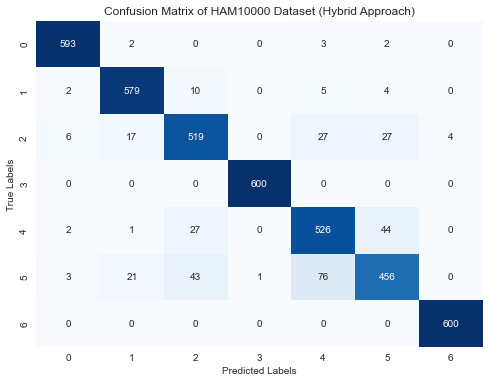

In [17]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, pred_rfc); print("Confusion Matrix:", cm)

# Plot the confusion matrix
plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of HAM10000 Dataset (Hybrid Approach)')
plt.show()

    Plot ROC curve

In [18]:
from sklearn.metrics import auc

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, rfc.predict_proba(X_test_pca), multi_class = 'ovr', average = 'weighted'); print("RFC ROC AUC:", roc_auc)

RFC ROC AUC: 0.9942398478835978
